In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys
import os

sys.path.append('../tools')
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch
from tqdm import tqdm
import sklearn

import torchvision.transforms as T
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
from models.rns_dataloader import get_data

import data_utility
import annotation_utility
import interactive_plot

In [3]:
data_dir = "../../../user_data/"
log_folder_root = '../../../user_data/logs/'
ckpt_folder_root = '../../../user_data/checkpoints/'

In [4]:
raw_annotations = pd.read_csv(data_dir + 'full_updated_anns_annotTbl_cleaned.csv')
ids = list(np.unique(raw_annotations[raw_annotations['descriptions'].notnull()]['HUP_ID']))
# ids = list(np.unique(raw_annotations['HUP_ID']))
ids

['HUP047',
 'HUP084',
 'HUP096',
 'HUP109',
 'HUP121',
 'HUP129',
 'HUP131',
 'HUP137',
 'HUP147',
 'HUP153',
 'HUP156',
 'HUP159',
 'HUP182',
 'HUP197',
 'HUP199',
 'HUP205',
 'RNS026',
 'RNS029']

In [5]:
# data_import = data_utility.read_files(path=data_dir+'rns_data', path_data=data_dir+'rns_raw_cache', patientIDs=ids,
#                                       verbose=True)  # Import data with annotation

In [6]:
# annotations = annotation_utility.read_annotation(annotation_path=data_dir +'full_updated_anns_annotTbl_cleaned.csv',
#                                                  data=data_import, n_class=3)

In [7]:
# np.random.seed(seed=42)
# annot = annotations.annotations
# annot_nonseizure = annot[annot['Class_Code'] == 0]
# annot_seizure = annot[annot['Class_Code'] == 1]
# patient_list = list(np.unique(annot['Patient_ID']))
# # patient_list = ['RNS026', 'HUP159', 'HUP129', 'HUP096', 'HUP182']
# clip_dict = {}
# for p in patient_list:
#     seizure_start_index = np.array([])
#     seizure_end_index = np.array([])
#     nonseizure_start_index = np.array([])
#     nonseizure_end_index = np.array([])
#     global_episode_index_seizure = np.array([])
#     global_episode_index_nonseizure = np.array([])
#     start_index = annot_seizure[annot_seizure['Patient_ID'] == p]['Episode_Start_Index']
#     end_index = annot_seizure[annot_seizure['Patient_ID'] == p]['Episode_End_Index']
#     annot_start_list = annot_seizure[annot_seizure['Patient_ID'] == p]['Annotation_Start_Index']
#     annot_end_list = annot_seizure[annot_seizure['Patient_ID'] == p]['Annotation_End_Index']
#     episode_index = annot_seizure[annot_seizure['Patient_ID'] == p]['Episode_Index']
#
#     for i, slel in enumerate(zip(annot_start_list, annot_end_list, episode_index.index)):
#         sl = slel[0]
#         el = slel[1]
#         ei = slel[2]
#
#         annot_array = np.vstack((sl, el))
#         seizure_start_index = np.hstack((seizure_start_index, annot_array[0, :]))
#         seizure_end_index = np.hstack((seizure_end_index, annot_array[1, :]))
#
#         nonseizure_start_index = np.hstack((nonseizure_start_index, start_index.iloc[i]))
#         nonseizure_end_index = np.hstack((nonseizure_end_index, annot_array[0, 0]))
#
#         nonseizure_start_index = np.hstack((nonseizure_start_index, annot_array[1, -1]))
#         nonseizure_end_index = np.hstack((nonseizure_end_index, end_index.iloc[i]))
#
#         if annot_array.shape[1] > 1:
#             nonseizure_start_index = np.hstack((nonseizure_start_index, annot_array[0, 1:]))
#             nonseizure_end_index = np.hstack((nonseizure_end_index, annot_array[1, :-1]))
#
#         global_episode_index_seizure = np.hstack((global_episode_index_seizure,
#                                                   np.repeat(ei, len(seizure_start_index) -
#                                                             len(global_episode_index_seizure))))
#         global_episode_index_nonseizure = np.hstack((global_episode_index_nonseizure,
#                                                      np.repeat(ei, len(nonseizure_start_index) -
#                                                                len(global_episode_index_nonseizure))))
#
#     assert len(global_episode_index_nonseizure) == len(nonseizure_start_index)
#     assert len(global_episode_index_seizure) == len(seizure_start_index)
#
#     start_index = annot_nonseizure[annot_nonseizure['Patient_ID'] == p]['Episode_Start_Index']
#     end_index = annot_nonseizure[annot_nonseizure['Patient_ID'] == p]['Episode_End_Index']
#     episode_index = start_index.index
#
#     nonseizure_ind_arr = np.vstack(
#         [nonseizure_start_index,
#          nonseizure_end_index,
#          global_episode_index_nonseizure]).astype(int)
#
#     seizure_ind_arr = np.vstack(
#         [seizure_start_index,
#          seizure_end_index,
#          global_episode_index_seizure]).astype(int)
#
#     nonseizure_ind_arr_eps = np.vstack(
#         [start_index,
#          end_index,
#          episode_index]).astype(int)
#
#     nonseizure_clip_temp = np.hstack((nonseizure_ind_arr, nonseizure_ind_arr_eps))
#     nonseizure_clip_label = np.zeros(nonseizure_clip_temp.shape[1]).astype(int)
#     non_seizure_clip = np.vstack((nonseizure_clip_temp, nonseizure_clip_label))
#
#     seizure_clip_temp = np.vstack(
#             [seizure_start_index,
#              seizure_end_index,
#              global_episode_index_seizure]).astype(int)
#     seizure_clip_label = np.ones(seizure_clip_temp.shape[1]).astype(int)
#     seizure_clip = np.vstack((seizure_clip_temp, seizure_clip_label))
#
#     combined_clip = np.hstack((seizure_clip, non_seizure_clip))
#
#
#     valid = np.where((combined_clip[1] - combined_clip[0]) > 500)
#
#     combined_clip = combined_clip[:,valid].squeeze()
#
#     if combined_clip.shape[1]>0:
#         shuffled_index = np.arange(combined_clip.shape[1])
#         np.random.shuffle(shuffled_index)
#         clip_dict[p] = combined_clip[:, shuffled_index]
#
# np.save(data_dir + 'rns_test_cache/clip_dict.npy', clip_dict)

In [8]:
# annot_len = {}
# for id in tqdm(clip_dict.keys()):
#     annot_len[id]=clip_dict[id].shape[1]
# annot_len

In [9]:
# annot_len_l = []
# for id in tqdm(clip_dict.keys()):
#     annot_len_l.append(clip_dict[id].shape[1])
# annot_len_l.sort()

In [10]:
# np.sort(annot_len_l)[::-1]

In [11]:
# window_len = 1
# stride = 1
# concat_n = 4
# for id in tqdm(clip_dict.keys()):
#     data_import[id].set_window_parameter(window_length=window_len, window_displacement=stride)
#     data_import[id].set_concatenation_parameter(concatenate_window_n=concat_n)
#     window_indices, _ = data_import[id].get_windowed_data(clip_dict[id][0], clip_dict[id][1])
#     import_label = np.array([])
#     for i, ind in enumerate(window_indices):
#         import_label = np.hstack((import_label, np.repeat(clip_dict[id][3][i], len(ind))))
#     data_import[id].normalize_windowed_data()
#     _, concatenated_data = data_import[id].get_concatenated_data(data_import[id].windowed_data, arrange='channel_stack')
#     assert import_label.shape[0] == concatenated_data.shape[0]
#     np.save(data_dir+'rns_test_cache/' + id + '.npy', {'data': concatenated_data, 'label': import_label})

In [12]:
from models.rns_dataloader import RNS_Downstream
from models.SwaV import SwaV

In [13]:
import torch
import torchvision
from torch import nn

from lightly.data import LightlyDataset, SwaVCollateFunction
from lightly.loss import SwaVLoss
from lightly.loss.memory_bank import MemoryBankModule
from lightly.models.modules import SwaVProjectionHead, SwaVPrototypes


In [14]:
def collate_fn(batch):
    info = list(zip(*batch))
    data = info[0]
    label = info[1]
    return torch.stack(data), torch.stack(label)

In [15]:
data_list = os.listdir(data_dir+'rns_test_cache')[1:]

# data_list = ['HUP182.npy',   'HUP129.npy',   'HUP109.npy', 'HUP156.npy', 'HUP096.npy', 'RNS026.npy',  'HUP159.npy']
# data_list = ['RNS026.npy', 'HUP159.npy', 'HUP129.npy', 'HUP096.npy', 'HUP182.npy']
train_data, train_label, test_data, test_label = get_data(data_list, split=0.7)
# data, label,_,_ = get_data(data_list, split=1)
# train_data, test_data, train_label, test_label = sklearn.model_selection.train_test_split(data, label, test_size=0.8, random_state=42)

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

100%|██████████| 16/16 [00:17<00:00,  1.09s/it]

(75559, 249, 36)
(75559,)
(32389, 249, 36)
(32389,)


In [16]:
print(test_label)

[0. 0. 0. ... 1. 1. 1.]


In [17]:
test_label.sum()

8802.0

In [18]:
from models.SupervisedDownstream import SupervisedDownstream

In [19]:
# ckpt = torch.load(ckpt_folder_root+ 'rns_checkpoints/rns_swav_ckpt_5_patients/checkpoint31.pth')
# resnet = torchvision.models.resnet50()
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# swav = SwaV()
# # swav.load_state_dict(ckpt['model_state_dict'])
# model = SupervisedDownstream(swav.backbone)
#

swav = SwaV().load_from_checkpoint(ckpt_folder_root + 'rns_swav_50_12/rns_swav-epoch=82-swav_loss=2.58204.ckpt')
model = SupervisedDownstream(swav.backbone)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

checkpoint_callback = pl_callbacks.ModelCheckpoint(monitor='val_loss',
                                                   filename='rns_swav_50_all_linear_eval-{epoch:02d}-{val_loss:.5f}', save_last=True, save_top_k=-1, dirpath=ckpt_folder_root + 'rns_swav_50_all_linear_eval')
csv_logger = pl_loggers.CSVLogger(log_folder_root, name='rns_swav_50_all_linear_eval')

trainer = pl.Trainer(logger=csv_logger, max_epochs=80, callbacks=[checkpoint_callback], accelerator='gpu', devices=1,precision=16)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [20]:
train_dataset = RNS_Downstream(train_data, train_label, transform=True, astensor=True)
test_dataset = RNS_Downstream(test_data, test_label, transform=False, astensor=True)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    # num_workers = 2
)

val_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)

trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | backbone | Sequential | 23.5 M
1 | fc1      | Linear     | 1.0 M 
2 | dp       | Dropout1d  | 0     
3 | fc2      | Linear     | 32.8 K
4 | fc3      | Linear     | 520   
5 | fc4      | Linear     | 18    
6 | softmax  | Softmax    | 0     
----------------------------------------
24.6 M    Trainable params
0         Non-trainable params
24.6 M    Total params
49.181    Total estimated model params size (MB)


data loaded
(75559, 249, 36)
(75559,)
data loaded
(32389, 249, 36)
(32389,)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [21]:
test_dataset = RNS_Downstream(test_data, test_label, transform=False, astensor=True)
val_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=True,
)

data loaded
(32389, 249, 36)
(32389,)


In [21]:
predictions = trainer.predict(model,val_dataloader,ckpt_path=ckpt_folder_root + 'rns_swav_50_all_linear_eval/rns_swav_50_all_linear_eval-epoch=06-val_loss=1.52025.ckpt')

Restoring states from the checkpoint path at ../../../user_data/checkpoints/rns_swav_50_all_linear_eval/rns_swav_50_all_linear_eval-epoch=06-val_loss=1.52025.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../../../user_data/checkpoints/rns_swav_50_all_linear_eval/rns_swav_50_all_linear_eval-epoch=06-val_loss=1.52025.ckpt
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 124it [00:00, ?it/s]

In [22]:
output_list = []
target_list = []
emb_list = []
m = nn.Softmax(dim=1)
for pred, y, emb in predictions:
    output_list.append(pred)
    target_list.append(y)
    emb_list.append(emb)

In [23]:
len(target_list)

127

In [24]:
pred_raw = torch.vstack(output_list)
target = torch.vstack(target_list)
emb = torch.vstack(emb_list)
out = torch.argmax(pred_raw, dim=1)

In [25]:
m(pred_raw.float())[:,0]

tensor([1.0000, 1.0000, 1.0000,  ..., 0.8110, 0.8072, 0.5960])

In [26]:
emb.shape

torch.Size([32389, 2048])

In [27]:
target.shape

torch.Size([32389, 1])

In [28]:
sklearn.metrics.accuracy_score(torch.argmax(pred_raw, dim=1), target)

0.9553552131896632

In [29]:
clf_report = sklearn.metrics.classification_report(torch.argmax(pred_raw, dim=1), target, digits=6)

print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0   0.981134  0.958539  0.969705     24143
           1   0.886276  0.946034  0.915181      8246

    accuracy                       0.955355     32389
   macro avg   0.933705  0.952287  0.942443     32389
weighted avg   0.956984  0.955355  0.955823     32389



In [33]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [34]:
len(emb)

32389

In [35]:
pca_comp_n = 30
batch_size = 32

pca = PCA(n_components=pca_comp_n, copy=True).fit(emb)
p = pca.transform(emb)

# ind = np.random.choice(len(emb), 10000)
#
tsne = TSNE(n_components=2, verbose=1, perplexity=75, random_state=142, init='pca')
z = tsne.fit_transform(emb)
interictal_inds = np.where(target == 0)[0]
ictal_inds = np.where(target == 1)[0]

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 226 nearest neighbors...
[t-SNE] Indexed 32389 samples in 0.031s...
[t-SNE] Computed neighbors for 32389 samples in 30.211s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32389
[t-SNE] Computed conditional probabilities for sample 2000 / 32389
[t-SNE] Computed conditional probabilities for sample 3000 / 32389
[t-SNE] Computed conditional probabilities for sample 4000 / 32389
[t-SNE] Computed conditional probabilities for sample 5000 / 32389
[t-SNE] Computed conditional probabilities for sample 6000 / 32389
[t-SNE] Computed conditional probabilities for sample 7000 / 32389
[t-SNE] Computed conditional probabilities for sample 8000 / 32389
[t-SNE] Computed conditional probabilities for sample 9000 / 32389
[t-SNE] Computed conditional probabilities for sample 10000 / 32389
[t-SNE] Computed conditional probabilities for sample 11000 / 32389
[t-SNE] Computed conditional probabilities for sample 12000 / 32389
[t-SNE] Computed conditional probabilities for s

C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.839149
[t-SNE] KL divergence after 1000 iterations: 1.032229


In [36]:
pca.explained_variance_ratio_

array([0.2144281 , 0.10020279, 0.07646883, 0.06442291, 0.04490002,
       0.04062132, 0.03569984, 0.02676817, 0.02298285, 0.02067377,
       0.0168047 , 0.01644357, 0.01457912, 0.0123805 , 0.01188476,
       0.01085319, 0.00998003, 0.00906975, 0.0084218 , 0.00815682,
       0.00708114, 0.00686117, 0.00602813, 0.00559595, 0.00533267,
       0.00481589, 0.00472538, 0.00461065, 0.00449321, 0.00446797])

In [37]:
len(interictal_inds)

23587

In [38]:
len(ictal_inds)

8802

In [39]:
# spc = p
#
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(spc[interictal_inds,0],spc[interictal_inds,1],spc[interictal_inds,2],c='gold',label= 'interictal')
# ax.scatter(spc[ictal_inds, 0], spc[ictal_inds, 1],spc[ictal_inds, 2], c='royalblue', label='ictal')
# # plt.title('Swav Embedding t-SNE')
# ax.set_xlabel('comp 1')
# ax.set_ylabel("comp 2")
# ax.set_zlabel("comp 2")
# plt.legend()
# # plt.xlim(-67, 74)
# # plt.ylim(-67, 75)
# plt.grid()
# # plt.show()

<IPython.core.display.Javascript object>


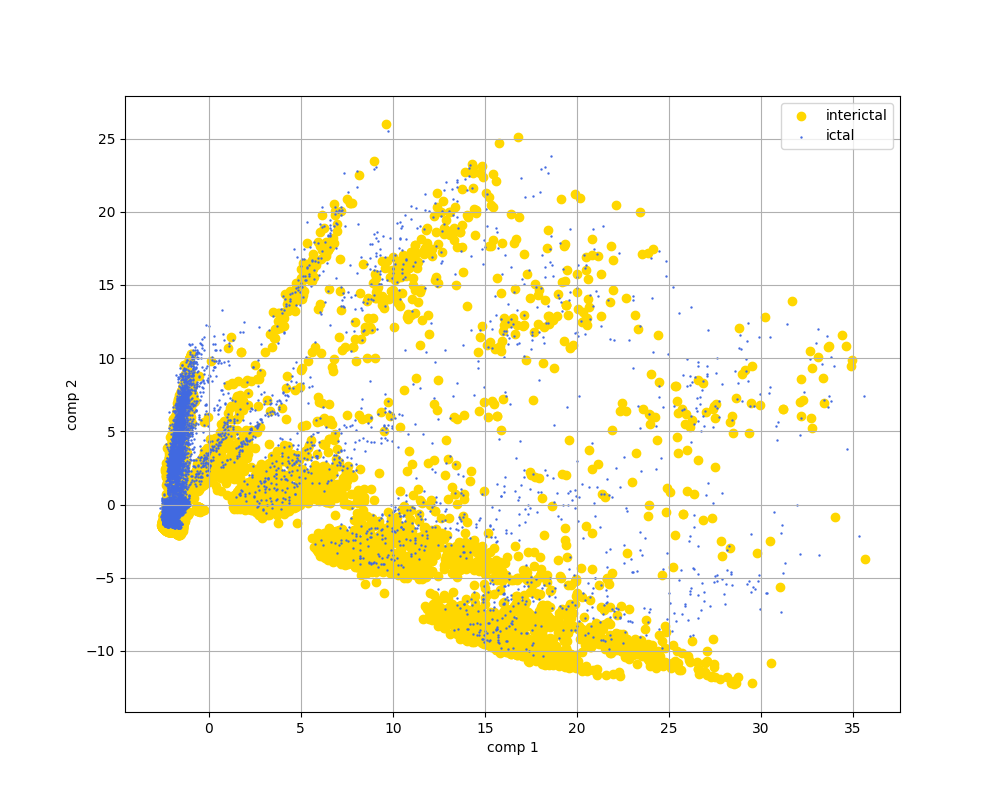

In [43]:
spc = p
plt.figure(figsize=(10, 8))
plt.scatter(spc[interictal_inds,0],spc[interictal_inds,1],c='gold',label= 'interictal')
plt.scatter(spc[ictal_inds, 0], spc[ictal_inds, 1], c='royalblue', label='ictal',s=0.5)
# plt.title('Swav Embedding t-SNE')
plt.xlabel('comp 1')
plt.ylabel("comp 2")
plt.legend()
# plt.xlim(-67, 74)
# plt.ylim(-67, 75)
plt.grid()
plt.show()

In [ ]:
# dt = np.vstack((z[:,0], z[:,1])).T
interactive_plot.interactive_plot(z, ['RNS026', 'HUP159', 'HUP129', 'HUP096'], data_import, color_override=target)

In [ ]:
interactive_plot.interactive_plot(z, ['HUP159'], data_import, color_override=target)

In [31]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(m(pred_raw.float()), target, pos_label=1)
sklearn.metrics.auc(fpr, tpr)

ValueError: continuous-multioutput format is not supported

<IPython.core.display.Javascript object>


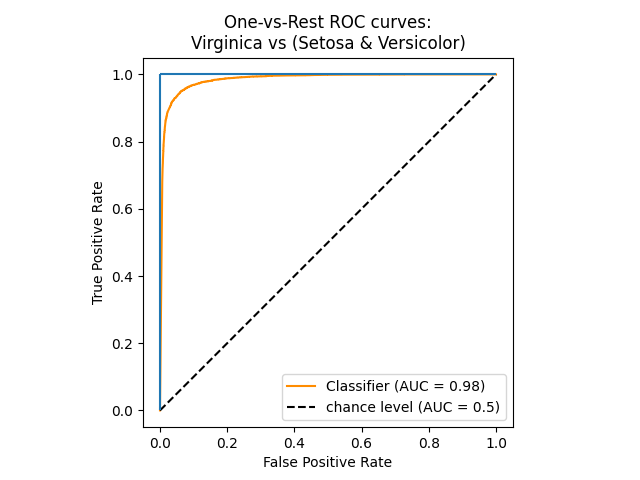

In [57]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_predictions(
    target,
    m(pred_raw.float())[:,1],
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.hlines(y = 1, xmin = 0, xmax = 1)
plt.vlines(x = 0, ymin = 0, ymax = 1)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


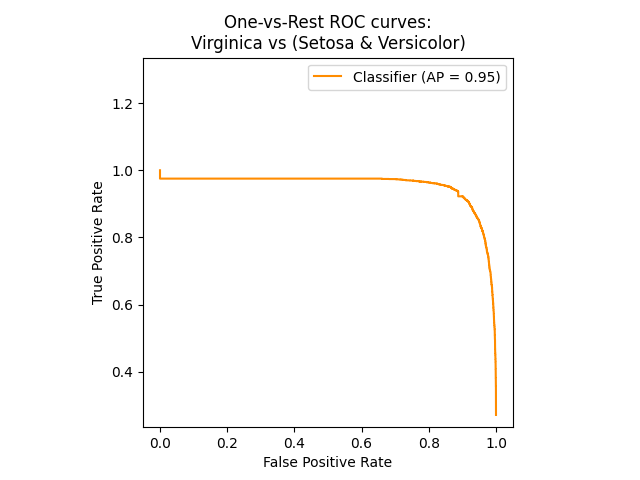

In [59]:
PrecisionRecallDisplay.from_predictions(
    target,
    m(pred_raw.float())[:,1],
    color="darkorange",
)
# plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [49]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(target,
    m(pred_raw.float())[:,1])
metrics.auc(fpr, tpr)

0.9848202355795314

In [ ]:
output[:, 1]

In [ ]:

output = torch.argmax(output, dim=1)
output = output.detach().cpu().numpy()
target = target.squeeze().detach().cpu().numpy()

In [ ]:
import sklearn

clf_report = sklearn.metrics.classification_report(output, target, digits=6)

print(f"Classification Report : \n{clf_report}")

In [ ]:
for batch, label in tqdm(val_dataloader):
    batch = batch.to(device)
    label = label.to(device)
    label = F.one_hot(label).squeeze()
    outputs = model(batch)
    print(batch)
    loss = sigmoid_focal_loss(pred.float(), label.float(), alpha=0.5, gamma=8, reduction='mean')
    print(loss)
    break

In [ ]:
# import copy
# import torch
# import torchvision
# from torch import nn
#
# from lightly.data import DINOCollateFunction, LightlyDataset
# from lightly.loss import DINOLoss
# from lightly.models.modules import DINOProjectionHead
# from lightly.models.utils import deactivate_requires_grad, update_momentum
# from lightly.utils.scheduler import cosine_schedule
#
#
# class DINO(torch.nn.Module):
#     def __init__(self, backbone, input_dim):
#         super().__init__()
#         self.student_backbone = backbone
#         self.student_head = DINOProjectionHead(
#             input_dim, 512, 64, 2048, freeze_last_layer=1
#         )
#         self.teacher_backbone = copy.deepcopy(backbone)
#         self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
#         deactivate_requires_grad(self.teacher_backbone)
#         deactivate_requires_grad(self.teacher_head)
#
#     def forward(self, x):
#         y = self.student_backbone(x).flatten(start_dim=1)
#         z = self.student_head(y)
#         return z
#
#     def forward_teacher(self, x):
#         y = self.teacher_backbone(x).flatten(start_dim=1)
#         z = self.teacher_head(y)
#         return z
#
#
# resnet = torchvision.models.resnet18()
# backbone = nn.Sequential(*list(resnet.children())[:-1])
# input_dim = 512
# # instead of a resnet you can also use a vision transformer backbone as in the
# # original paper (you might have to reduce the batch size in this case):
# # backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=False)
# # input_dim = backbone.embed_dim
#
# model = DINO(backbone, input_dim)
#
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)
#
# # # we ignore object detection annotations by setting target_transform to return 0
# # pascal_voc = torchvision.datasets.VOCDetection(
# #     "datasets/pascal_voc", download=True, target_transform=lambda t: 0
# # )
# # dataset = LightlyDataset.from_torch_dataset(pascal_voc)
# # # or create a dataset from a folder containing images or videos:
# # # dataset = LightlyDataset("path/to/folder")
#
# collate_fn = DINOCollateFunction(solarization_prob = 0, hf_prob = 0,vf_prob = 0,rr_prob=0,cj_prob=0,random_gray_scale=0)
#
# dataloader = torch.utils.data.DataLoader(
#     train_set,
#     batch_size=64,
#     collate_fn=collate_fn,
#     shuffle=True,
#     drop_last=True,
#     num_workers=1,
# )
#
# criterion = DINOLoss(
#     output_dim=2048,
#     warmup_teacher_temp_epochs=5,
# )
# # move loss to correct device because it also contains parameters
# criterion = criterion.to(device)
#
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
# epochs = 10
#
# print("Starting Training")
# for epoch in range(epochs):
#     total_loss = 0
#     momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)
#     for views, _, _ in tqdm(dataloader):
#         update_momentum(model.student_backbone, model.teacher_backbone, m=momentum_val)
#         update_momentum(model.student_head, model.teacher_head, m=momentum_val)
#         views = [view.to(device) for view in views]
#         global_views = views[:2]
#         teacher_out = [model.forward_teacher(view) for view in global_views]
#         student_out = [model.forward(view) for view in views]
#         loss = criterion(teacher_out, student_out, epoch=epoch)
#         total_loss += loss.detach()
#         loss.backward()
#         # We only cancel gradients of student head.
#         model.student_head.cancel_last_layer_gradients(current_epoch=epoch)
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")

In [ ]:
augmentation = T.Compose([
    T.ToPILImage(),
    T.Resize((256, 512), interpolation=T.InterpolationMode.NEAREST),
    T.RandomApply([T.ColorJitter()], p=0.5),
    T.RandomApply([T.GaussianBlur(kernel_size=(3, 3))], p=0.5),
    T.RandomInvert(p=0.2),
    T.RandomPosterize(4, p=0.2),
])

data = ictal_data_X[0]

channel_index = np.arange(data.shape[0])
np.random.shuffle(channel_index)
data = data[channel_index]
data = torch.from_numpy(data).clone()
data = data.repeat(3, 1, 1)
data = augmentation(data)
data

In [ ]:
channel_index

In [ ]:
data[channel_index]

In [ ]:
data

In [ ]:
#
# print("Starting Training")
# for epoch in range(50):
#     total_loss = 0
#     i = 0
#     for batch, label in tqdm(dataloader):
#         batch = batch.to(device)
#         # print(type(batch))
#         label = label.to(device)
#         label = F.one_hot(label).squeeze()
#         outputs = model(batch)
#         loss = sigmoid_focal_loss(outputs.float(),label.float(), alpha = 0.25, gamma = 7,reduction = 'mean')
#         total_loss += loss.detach()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#     avg_loss = total_loss / len(dataloader)
#     torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': avg_loss,
#             }, 'ckpt/checkpoint'+str(epoch)+'.pth')
#
#     print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")